<a href="https://colab.research.google.com/github/acse-gcm20/YOLOv3-CDA/blob/master/Workflow2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOv3 Crater Detection Algorithm Workflow
---
### Giles Matthews

## Setup

In [1]:
print("---  Cloning repository  ---\n")
! git clone https://github.com/acse-gcm20/YOLOv3-CDA
print("\n---  Installing dependencies  ---\n")
! pip install -r /content/YOLOv3-CDA/requirements.txt
print("\nNow restart the Runtime before proceeding")

---  Cloning repository  ---

Cloning into 'YOLOv3-CDA'...
remote: Enumerating objects: 9270, done.
remote: Counting objects: 100% (307/307), done.
remote: Compressing objects: 100% (247/247), done.
remote: Total 9270 (delta 126), reused 239 (delta 59), pack-reused 8963
Receiving objects: 100% (9270/9270), 394.78 MiB | 17.34 MiB/s, done.
Resolving deltas: 100% (1261/1261), done.
Checking out files: 100% (7297/7297), done.

---  Installing dependencies  ---

     |████████████████████████████████| 11.6MB 7.7MB/s 
     |████████████████████████████████| 10.6MB 32.7MB/s 
     |████████████████████████████████| 2.2MB 26.8MB/s 
     |████████████████████████████████| 71kB 7.9MB/s 
     |████████████████████████████████| 952kB 36.6MB/s 
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=5bdd7f31ae52d974d90232a013489e58b2583726d4081c8e89241d9901c01d74
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d88


Now restart the Runtime before proceeding


In [1]:
%cd /content/YOLOv3-CDA

import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from sklearn.metrics import auc

from pytorchyolo.train import run
from pytorchyolo.test import evaluate_model_file
from pytorchyolo.detect import detect_directory

# Utility function to write lists to a text file
def list_to_file(list_array, filename):
    dims = len(np.shape(list_array))
    
    if dims == 1:
        rows = len(list_array)
        cols = 1
    else:
        rows = len(list_array[0])
        cols = len(list_array)

    with open(filename, 'w') as f:
        for row in range(rows):
            vals = [list_array[col][row] for col in range(cols)]
            f.write(("{} "*cols+'\n').format(*vals))

# Statistics utility functions
def plot_stats(stats_file):
    training_losses = []
    validation_losses = []
    precision_vals = []
    recall_vals = []

    with open(stats_file) as f:
        for line in f:
            tl, vl, precision, recall = line.rstrip("\n").split()
            training_losses.append(float(tl))
            validation_losses.append(float(vl))
            precision_vals.append(float(precision))
            recall_vals.append(float(recall))

    epochs = len(training_losses)

    fig, axs = plt.subplots(2, 2, figsize=(16, 16))

    axs[0,0].plot(range(1, epochs+1), training_losses, label="Training Loss")
    axs[0,0].plot(range(1, epochs+1), validation_losses, label="Validation Loss")
    axs[0,0].set_xlim(1, epochs)
    axs[0,0].set_xlabel("Epoch")
    axs[0,0].set_ylabel("Loss")
    axs[0,0].legend()
    axs[0,0].grid(True)

    axs[0,1].scatter(recall_vals, precision_vals)
    axs[0,1].set_xlim(-0.1, 1.1)
    axs[0,1].set_ylim(-0.1, 1.1)
    axs[0,1].set_xlabel("Recall")
    axs[0,1].set_ylabel("Precision")
    axs[0,1].grid(True)

    axs[1,0].scatter(range(1, epochs+1), recall_vals)
    axs[1,0].set_xlim(1, epochs)
    axs[1,0].set_ylim(-0.1, 1.1)
    axs[1,0].set_xlabel("Epoch")
    axs[1,0].set_ylabel("Recall")
    axs[1,0].grid(True)

    axs[1,1].scatter(range(1, epochs+1), precision_vals)
    axs[1,1].set_xlim(1, epochs)
    axs[1,1].set_ylim(-0.1, 1.1)
    axs[1,1].set_xlabel("Epoch")
    axs[1,1].set_ylabel("Precision")
    axs[1,1].grid(True)

# Class to calculate, save and plot Precision-Recall curves
class PRcurve:
    def __init__(self, weights_path, start=0.05, stop=0.5, n=10):
        self.confs = np.linspace(start, stop, num=n)
        self.precisions = []
        self.recalls = []

        for i, conf in enumerate(self.confs):
            print("\n%i/%i: Confidence Threshold = %.3f" % (i+1, n, conf))
            metrics = evaluate_model_file('yolov3.cfg', weights_path, 'data/valid.txt', ['crater'], batch_size=32, n_cpu=2, conf_thres=conf, verbose=False)
            self.precisions.append(float(metrics[0]))
            self.recalls.append(float(metrics[1]))
            print("Precision = %.3f, Recall = %.3f" % (metrics[0], metrics[1]))

        list_to_file([self.precisions, self.recalls], "PRstats.txt")
        self.auc_score = auc(self.recalls, self.precisions)

    def save_stats(self, filename):
        list_to_file([self.precisions, self.recalls], filename)

    def plot(self):
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))

        ax.plot(self.recalls, self.precisions)
        ax.set_title("Validation Set Precision-Recall Curve, AUC = %.2f" % self.auc_score)
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.grid(True)

/content/YOLOv3-CDA


In [3]:
# Download weights pretrained on COCO
! wget -c "https://pjreddie.com/media/files/yolov3.weights" --header "Referer: pjreddie.com"

--2021-07-13 14:53:50--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  91.8MB/s    in 2.6s    

2021-07-13 14:53:53 (91.8 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



## Data Organisation

In [2]:
# Organise THEMIS data intro training, validation and test sets
imageFolder = "/content/YOLOv3-CDA/data/images/"
labelFolder = "/content/YOLOv3-CDA/data/labels/"

pathsFile = "/content/YOLOv3-CDA/data/all.txt"
trainFile = "/content/YOLOv3-CDA/data/train.txt"
valFile = "/content/YOLOv3-CDA/data/valid.txt"
testFile = "/content/YOLOv3-CDA/data/test.txt"

# Walk through image folder and write paths to all.txt, also count number of files
with open(pathsFile, "w") as all:
    n = 0
    for root, dirs, files in os.walk(imageFolder):
        for file in files:
            all.write(imageFolder+file+"\n")
            n += 1

# 90% of data into training set
trainSize = int(n * 0.9)
# 10% of training set into validation set
valSize = int(trainSize * 0.1)
trainSize -= valSize
# 10% of data into test set
testSize = n - (trainSize + valSize)

# Ensure dataset sizes are correct
try:
    assert n == trainSize + valSize + testSize
    print("Total:", n, "\nTraining Size:", trainSize, "\nValidation Size:", valSize, "\nTest Size:", testSize)
except:
    print("Invalid Split")

# Get random indices lists according to dataset sizes
train_idx, val_idx, test_idx = torch.utils.data.random_split(range(n), [trainSize, valSize, testSize], generator=torch.Generator().manual_seed(42))

Total: 3556 
Training Size: 2880 
Validation Size: 320 
Test Size: 356


In [4]:
# Organise image path files

# Get list of all image paths
with open(pathsFile, "r") as paths:
    pathsList = paths.readlines()

# Store train/val/test paths as lists
trainList = [pathsList[i].rstrip('\n') for i in train_idx]
valList = [pathsList[i].rstrip('\n') for i in val_idx]
testList = [pathsList[i].rstrip('\n') for i in test_idx]

# Write path lists to files
list_to_file([trainList], trainFile)
list_to_file([valList], valFile)
list_to_file([testList], testFile)

print("Training paths:\t\t", trainFile, "\nValidation paths:\t", valFile, "\nTest paths:\t\t", testFile)

Training paths:		 /content/YOLOv3-CDA/data/train.txt 
Validation paths:	 /content/YOLOv3-CDA/data/valid.txt 
Test paths:		 /content/YOLOv3-CDA/data/test.txt


In [4]:
# Pull any edits
! git pull https://github.com/acse-gcm20/YOLOv3-CDA
print("\nNow restart the Runtime and re-import modules before proceeding")

remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 10 (delta 6), reused 10 (delta 6), pack-reused 0
Unpacking objects: 100% (10/10), done.
From https://github.com/acse-gcm20/YOLOv3-CDA
 * branch            HEAD       -> FETCH_HEAD
Updating 3f84109..4737b3f
Fast-forward
 HiRISE_processing.py                  |  61 ++++++++++++++++------------------
 data/HiRISE/{ => tiles}/tile_0_0.jpg  | Bin
 data/HiRISE/{ => tiles}/tile_0_1.jpg  | Bin
 data/HiRISE/{ => tiles}/tile_0_2.jpg  | Bin
 data/HiRISE/{ => tiles}/tile_0_3.jpg  | Bin
 data/HiRISE/{ => tiles}/tile_0_4.jpg  | Bin
 data/HiRISE/{ => tiles}/tile_10_0.jpg | Bin
 data/HiRISE/{ => tiles}/tile_10_1.jpg | Bin
 data/HiRISE/{ => tiles}/tile_10_2.jpg | Bin
 data/HiRISE/{ => tiles}/tile_10_3.jpg | Bin
 data/HiRISE/{ => tiles}/tile_10_4.jpg | Bin
 data/HiRISE/{ => tiles}/tile_11_0.jpg | Bin
 data/HiRISE/{ => tiles}/tile_11_1.jpg | Bin
 data/HiRISE/{ 

## Training

In [2]:
# Run training sequence
run(epochs=50, pretrained_weights='/content/drive/MyDrive/CDA/ckpt_50_pt.pth', append_file='/content/drive/MyDrive/CDA/stats_100_pt.txt')

Training

Epochs: 50, Seed: 42


Training Epoch 0:   0%|          | 0/180 [00:00<?, ?it/s]


Epoch: 0
---- Training Model ----


Training Epoch 0: 100%|██████████| 180/180 [02:08<00:00,  1.40it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 463.97it/s]


---- mAP 0.69859 ----
Precision: 0.8048359240069085, Recall: 0.7467948717948718
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_0.pth' ----


Training Epoch 1:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.7562574148178101
Validation loss: 0.5947914719581604

Epoch: 1
---- Training Model ----


Training Epoch 1: 100%|██████████| 180/180 [02:24<00:00,  1.25it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 195.84it/s]


---- mAP 0.69921 ----
Precision: 0.8391224862888482, Recall: 0.7355769230769231
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_1.pth' ----


Training Epoch 2:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.6103630661964417
Validation loss: 0.5746393203735352

Epoch: 2
---- Training Model ----


Training Epoch 2: 100%|██████████| 180/180 [02:18<00:00,  1.30it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 235.46it/s]


---- mAP 0.69974 ----
Precision: 0.8582089552238806, Recall: 0.7371794871794872
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_2.pth' ----


Training Epoch 3:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.5578837394714355
Validation loss: 0.5599732398986816

Epoch: 3
---- Training Model ----


Training Epoch 3: 100%|██████████| 180/180 [02:11<00:00,  1.37it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 290.36it/s]


---- mAP 0.68328 ----
Precision: 0.839851024208566, Recall: 0.7227564102564102
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_3.pth' ----


Training Epoch 4:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.6162765622138977
Validation loss: 0.5497854948043823

Epoch: 4
---- Training Model ----


Training Epoch 4: 100%|██████████| 180/180 [02:11<00:00,  1.37it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 290.22it/s]


---- mAP 0.67909 ----
Precision: 0.8560460652591171, Recall: 0.7147435897435898
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_4.pth' ----


Training Epoch 5:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.7121108770370483
Validation loss: 0.5518506765365601

Epoch: 5
---- Training Model ----


Training Epoch 5: 100%|██████████| 180/180 [02:10<00:00,  1.38it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 301.73it/s]


---- mAP 0.68844 ----
Precision: 0.8428835489833642, Recall: 0.7307692307692307
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_5.pth' ----


Training Epoch 6:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.6599151492118835
Validation loss: 0.5369300246238708

Epoch: 6
---- Training Model ----


Training Epoch 6: 100%|██████████| 180/180 [02:19<00:00,  1.29it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 288.94it/s]


---- mAP 0.69207 ----
Precision: 0.851024208566108, Recall: 0.7323717948717948
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_6.pth' ----


Training Epoch 7:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.6559774279594421
Validation loss: 0.5348955988883972

Epoch: 7
---- Training Model ----


Training Epoch 7: 100%|██████████| 180/180 [02:02<00:00,  1.47it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 327.27it/s]


---- mAP 0.67438 ----
Precision: 0.833641404805915, Recall: 0.7227564102564102
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_7.pth' ----


Training Epoch 8:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.7240415811538696
Validation loss: 0.5293936133384705

Epoch: 8
---- Training Model ----


Training Epoch 8: 100%|██████████| 180/180 [02:19<00:00,  1.29it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 195.78it/s]


---- mAP 0.69132 ----
Precision: 0.8297491039426523, Recall: 0.7419871794871795
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_8.pth' ----


Training Epoch 9:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.6670112013816833
Validation loss: 0.5326671600341797

Epoch: 9
---- Training Model ----


Training Epoch 9: 100%|██████████| 180/180 [02:12<00:00,  1.36it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 316.84it/s]


---- mAP 0.68933 ----
Precision: 0.8303249097472925, Recall: 0.7371794871794872
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_9.pth' ----


Training Epoch 10:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.7132903337478638
Validation loss: 0.5332809090614319

Epoch: 10
---- Training Model ----


Training Epoch 10: 100%|██████████| 180/180 [02:11<00:00,  1.37it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 248.54it/s]


---- mAP 0.70651 ----
Precision: 0.8219895287958116, Recall: 0.7548076923076923
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_10.pth' ----


Training Epoch 11:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.5980639457702637
Validation loss: 0.5262900590896606

Epoch: 11
---- Training Model ----


Training Epoch 11: 100%|██████████| 180/180 [02:12<00:00,  1.36it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 213.64it/s]


---- mAP 0.70382 ----
Precision: 0.8333333333333334, Recall: 0.7532051282051282
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_11.pth' ----


Training Epoch 12:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.5934769511222839
Validation loss: 0.5306001901626587

Epoch: 12
---- Training Model ----


Training Epoch 12: 100%|██████████| 180/180 [02:11<00:00,  1.36it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 267.41it/s]


---- mAP 0.69641 ----
Precision: 0.8333333333333334, Recall: 0.7451923076923077
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_12.pth' ----


Training Epoch 13:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.5931529998779297
Validation loss: 0.5305727124214172

Epoch: 13
---- Training Model ----


Training Epoch 13: 100%|██████████| 180/180 [02:02<00:00,  1.47it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 187.45it/s]


---- mAP 0.72575 ----
Precision: 0.821247892074199, Recall: 0.780448717948718
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_13.pth' ----


Training Epoch 14:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.5612757205963135
Validation loss: 0.5294609069824219

Epoch: 14
---- Training Model ----


Training Epoch 14: 100%|██████████| 180/180 [02:18<00:00,  1.30it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 255.88it/s]


---- mAP 0.71158 ----
Precision: 0.8333333333333334, Recall: 0.7612179487179487
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_14.pth' ----


Training Epoch 15:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.781865119934082
Validation loss: 0.53121018409729

Epoch: 15
---- Training Model ----


Training Epoch 15: 100%|██████████| 180/180 [02:14<00:00,  1.33it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 507.36it/s]


---- mAP 0.68300 ----
Precision: 0.833941605839416, Recall: 0.7323717948717948
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_15.pth' ----


Training Epoch 16:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.5435227155685425
Validation loss: 0.536450982093811

Epoch: 16
---- Training Model ----


Training Epoch 16: 100%|██████████| 180/180 [02:03<00:00,  1.46it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 299.36it/s]


---- mAP 0.71289 ----
Precision: 0.8198970840480274, Recall: 0.7660256410256411
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_16.pth' ----


Training Epoch 17:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.6423391103744507
Validation loss: 0.5234965682029724

Epoch: 17
---- Training Model ----


Training Epoch 17: 100%|██████████| 180/180 [02:16<00:00,  1.32it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 235.13it/s]


---- mAP 0.70626 ----
Precision: 0.831858407079646, Recall: 0.7532051282051282
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_17.pth' ----


Training Epoch 18:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.6761255860328674
Validation loss: 0.525274395942688

Epoch: 18
---- Training Model ----


Training Epoch 18: 100%|██████████| 180/180 [02:14<00:00,  1.34it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 249.07it/s]


---- mAP 0.70380 ----
Precision: 0.8368794326241135, Recall: 0.7564102564102564
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_18.pth' ----


Training Epoch 19:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.7739818692207336
Validation loss: 0.5250949859619141

Epoch: 19
---- Training Model ----


Training Epoch 19: 100%|██████████| 180/180 [02:06<00:00,  1.43it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 200.14it/s]


---- mAP 0.71339 ----
Precision: 0.8235294117647058, Recall: 0.7628205128205128
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_19.pth' ----


Training Epoch 20:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.5673450231552124
Validation loss: 0.5321612358093262

Epoch: 20
---- Training Model ----


Training Epoch 20: 100%|██████████| 180/180 [02:06<00:00,  1.42it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 260.53it/s]


---- mAP 0.69396 ----
Precision: 0.823321554770318, Recall: 0.7467948717948718
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_20.pth' ----


Training Epoch 21:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.5941444635391235
Validation loss: 0.5294262170791626

Epoch: 21
---- Training Model ----


Training Epoch 21: 100%|██████████| 180/180 [02:12<00:00,  1.36it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 241.50it/s]


---- mAP 0.69016 ----
Precision: 0.8235294117647058, Recall: 0.7403846153846154
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_21.pth' ----


Training Epoch 22:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.5945262312889099
Validation loss: 0.5296624302864075

Epoch: 22
---- Training Model ----


Training Epoch 22: 100%|██████████| 180/180 [02:20<00:00,  1.28it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 270.76it/s]


---- mAP 0.67748 ----
Precision: 0.8481973434535104, Recall: 0.7163461538461539
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_22.pth' ----


Training Epoch 23:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.5937478542327881
Validation loss: 0.5165762901306152

Epoch: 23
---- Training Model ----


Training Epoch 23: 100%|██████████| 180/180 [02:15<00:00,  1.33it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 282.77it/s]


---- mAP 0.67827 ----
Precision: 0.8254545454545454, Recall: 0.7275641025641025
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_23.pth' ----


Training Epoch 24:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.5481320023536682
Validation loss: 0.525794267654419

Epoch: 24
---- Training Model ----


Training Epoch 24: 100%|██████████| 180/180 [02:16<00:00,  1.32it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 251.70it/s]


---- mAP 0.68467 ----
Precision: 0.8199643493761141, Recall: 0.7371794871794872
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_24.pth' ----


Training Epoch 25:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.5407367944717407
Validation loss: 0.5173342227935791

Epoch: 25
---- Training Model ----


Training Epoch 25: 100%|██████████| 180/180 [02:14<00:00,  1.34it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 195.57it/s]


---- mAP 0.69099 ----
Precision: 0.8084358523725835, Recall: 0.7371794871794872
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_25.pth' ----


Training Epoch 26:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.5538815259933472
Validation loss: 0.515978217124939

Epoch: 26
---- Training Model ----


Training Epoch 26: 100%|██████████| 180/180 [02:22<00:00,  1.26it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 447.25it/s]


---- mAP 0.70480 ----
Precision: 0.8369175627240143, Recall: 0.7483974358974359
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_26.pth' ----


Training Epoch 27:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.6944433450698853
Validation loss: 0.5296039581298828

Epoch: 27
---- Training Model ----


Training Epoch 27: 100%|██████████| 180/180 [02:05<00:00,  1.44it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 169.80it/s]


---- mAP 0.70053 ----
Precision: 0.8218694885361552, Recall: 0.7467948717948718
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_27.pth' ----


Training Epoch 28:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.5759714245796204
Validation loss: 0.5173429846763611

Epoch: 28
---- Training Model ----


Training Epoch 28: 100%|██████████| 180/180 [02:16<00:00,  1.32it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 278.04it/s]


---- mAP 0.67297 ----
Precision: 0.8315018315018315, Recall: 0.7275641025641025
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_28.pth' ----


Training Epoch 29:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.47547438740730286
Validation loss: 0.5262859463691711

Epoch: 29
---- Training Model ----


Training Epoch 29: 100%|██████████| 180/180 [02:14<00:00,  1.34it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 238.39it/s]


---- mAP 0.67950 ----
Precision: 0.8302919708029197, Recall: 0.7291666666666666
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_29.pth' ----


Training Epoch 30:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.5832230448722839
Validation loss: 0.5265528559684753

Epoch: 30
---- Training Model ----


Training Epoch 30: 100%|██████████| 180/180 [02:05<00:00,  1.44it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 441.41it/s]


---- mAP 0.71895 ----
Precision: 0.8084033613445378, Recall: 0.7708333333333334
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_30.pth' ----


Training Epoch 31:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.592479407787323
Validation loss: 0.5208204984664917

Epoch: 31
---- Training Model ----


Training Epoch 31: 100%|██████████| 180/180 [02:21<00:00,  1.27it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 303.50it/s]


---- mAP 0.70295 ----
Precision: 0.8345195729537367, Recall: 0.7516025641025641
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_31.pth' ----


Training Epoch 32:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.6246019005775452
Validation loss: 0.5102471113204956

Epoch: 32
---- Training Model ----


Training Epoch 32: 100%|██████████| 180/180 [02:00<00:00,  1.50it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 269.02it/s]


---- mAP 0.69485 ----
Precision: 0.8169014084507042, Recall: 0.7435897435897436
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_32.pth' ----


Training Epoch 33:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.5970525145530701
Validation loss: 0.5124857425689697

Epoch: 33
---- Training Model ----


Training Epoch 33: 100%|██████████| 180/180 [02:09<00:00,  1.39it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 499.74it/s]


---- mAP 0.70689 ----
Precision: 0.8102564102564103, Recall: 0.7596153846153846
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_33.pth' ----


Training Epoch 34:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.640206515789032
Validation loss: 0.5149993300437927

Epoch: 34
---- Training Model ----


Training Epoch 34: 100%|██████████| 180/180 [02:19<00:00,  1.29it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 153.12it/s]


---- mAP 0.69223 ----
Precision: 0.8309352517985612, Recall: 0.7403846153846154
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_34.pth' ----


Training Epoch 35:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.6312286257743835
Validation loss: 0.5207535028457642

Epoch: 35
---- Training Model ----


Training Epoch 35: 100%|██████████| 180/180 [02:13<00:00,  1.35it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 232.42it/s]


---- mAP 0.69921 ----
Precision: 0.8303571428571429, Recall: 0.7451923076923077
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_35.pth' ----


Training Epoch 36:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.7073906660079956
Validation loss: 0.5237533450126648

Epoch: 36
---- Training Model ----


Training Epoch 36: 100%|██████████| 180/180 [02:23<00:00,  1.26it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 256.50it/s]


---- mAP 0.69169 ----
Precision: 0.8360655737704918, Recall: 0.7355769230769231
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_36.pth' ----


Training Epoch 37:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.5315116047859192
Validation loss: 0.5111587643623352

Epoch: 37
---- Training Model ----


Training Epoch 37: 100%|██████████| 180/180 [02:19<00:00,  1.29it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 183.09it/s]


---- mAP 0.65404 ----
Precision: 0.8371647509578544, Recall: 0.7003205128205128
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_37.pth' ----


Training Epoch 38:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.6996821761131287
Validation loss: 0.5109633207321167

Epoch: 38
---- Training Model ----


Training Epoch 38: 100%|██████████| 180/180 [02:08<00:00,  1.40it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 274.82it/s]


---- mAP 0.70790 ----
Precision: 0.8085470085470086, Recall: 0.7580128205128205
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_38.pth' ----


Training Epoch 39:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.6121569871902466
Validation loss: 0.5256457924842834

Epoch: 39
---- Training Model ----


Training Epoch 39: 100%|██████████| 180/180 [02:09<00:00,  1.39it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 233.32it/s]


---- mAP 0.73022 ----
Precision: 0.7925445705024311, Recall: 0.7836538461538461
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_39.pth' ----


Training Epoch 40:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.632174015045166
Validation loss: 0.5142489075660706

Epoch: 40
---- Training Model ----


Training Epoch 40: 100%|██████████| 180/180 [02:13<00:00,  1.35it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 293.06it/s]


---- mAP 0.70491 ----
Precision: 0.8219895287958116, Recall: 0.7548076923076923
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_40.pth' ----


Training Epoch 41:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.6316038966178894
Validation loss: 0.5186127424240112

Epoch: 41
---- Training Model ----


Training Epoch 41: 100%|██████████| 180/180 [02:05<00:00,  1.44it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 194.15it/s]


---- mAP 0.71595 ----
Precision: 0.8101694915254237, Recall: 0.7660256410256411
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_41.pth' ----


Training Epoch 42:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.6450580358505249
Validation loss: 0.5149548053741455

Epoch: 42
---- Training Model ----


Training Epoch 42: 100%|██████████| 180/180 [02:12<00:00,  1.36it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 371.05it/s]


---- mAP 0.68923 ----
Precision: 0.827027027027027, Recall: 0.7355769230769231
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_42.pth' ----


Training Epoch 43:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.5891611576080322
Validation loss: 0.5193164944648743

Epoch: 43
---- Training Model ----


Training Epoch 43: 100%|██████████| 180/180 [02:08<00:00,  1.40it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 240.93it/s]


---- mAP 0.71132 ----
Precision: 0.8067226890756303, Recall: 0.7692307692307693
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_43.pth' ----


Training Epoch 44:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.6213350296020508
Validation loss: 0.5194500088691711

Epoch: 44
---- Training Model ----


Training Epoch 44: 100%|██████████| 180/180 [02:11<00:00,  1.37it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 138.18it/s]


---- mAP 0.72592 ----
Precision: 0.7976973684210527, Recall: 0.7772435897435898
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_44.pth' ----


Training Epoch 45:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.6087815165519714
Validation loss: 0.5062640309333801

Epoch: 45
---- Training Model ----


Training Epoch 45: 100%|██████████| 180/180 [02:19<00:00,  1.29it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 286.79it/s]


---- mAP 0.70773 ----
Precision: 0.8245614035087719, Recall: 0.7532051282051282
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_45.pth' ----


Training Epoch 46:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.5480185747146606
Validation loss: 0.5063958168029785

Epoch: 46
---- Training Model ----


Training Epoch 46: 100%|██████████| 180/180 [02:16<00:00,  1.32it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 255.42it/s]


---- mAP 0.67854 ----
Precision: 0.8132854578096947, Recall: 0.7259615384615384
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_46.pth' ----


Training Epoch 47:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.6016433835029602
Validation loss: 0.504883348941803

Epoch: 47
---- Training Model ----


Training Epoch 47: 100%|██████████| 180/180 [02:01<00:00,  1.48it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 229.67it/s]


---- mAP 0.69906 ----
Precision: 0.7969543147208121, Recall: 0.7548076923076923
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_47.pth' ----


Training Epoch 48:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.5620502829551697
Validation loss: 0.5130414366722107

Epoch: 48
---- Training Model ----


Training Epoch 48: 100%|██████████| 180/180 [02:15<00:00,  1.33it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 242.18it/s]


---- mAP 0.69134 ----
Precision: 0.8193202146690519, Recall: 0.7339743589743589
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_48.pth' ----


Training Epoch 49:   0%|          | 0/180 [00:00<?, ?it/s]


---Evaluation---
Training Loss 0.5961825251579285
Validation loss: 0.5260945558547974

Epoch: 49
---- Training Model ----


Training Epoch 49: 100%|██████████| 180/180 [02:06<00:00,  1.42it/s]


---- Validating Model ----



Computing AP: 100%|██████████| 1/1 [00:00<00:00, 170.60it/s]


---- mAP 0.70184 ----
Precision: 0.7983050847457627, Recall: 0.7548076923076923
---- Saving checkpoint to: 'checkpoints/yolov3_ckpt_49.pth' ----

---Evaluation---
Training Loss 0.633545994758606
Validation loss: 0.5120260119438171


In [5]:
# Copy weights to google drive
!cp checkpoints/yolov3_ckpt_49.pth /content/drive/MyDrive/CDA

## Analysis and Plotting

In [ ]:
plot_stats('/content/drive/MyDrive/CDA/stats_50.txt')

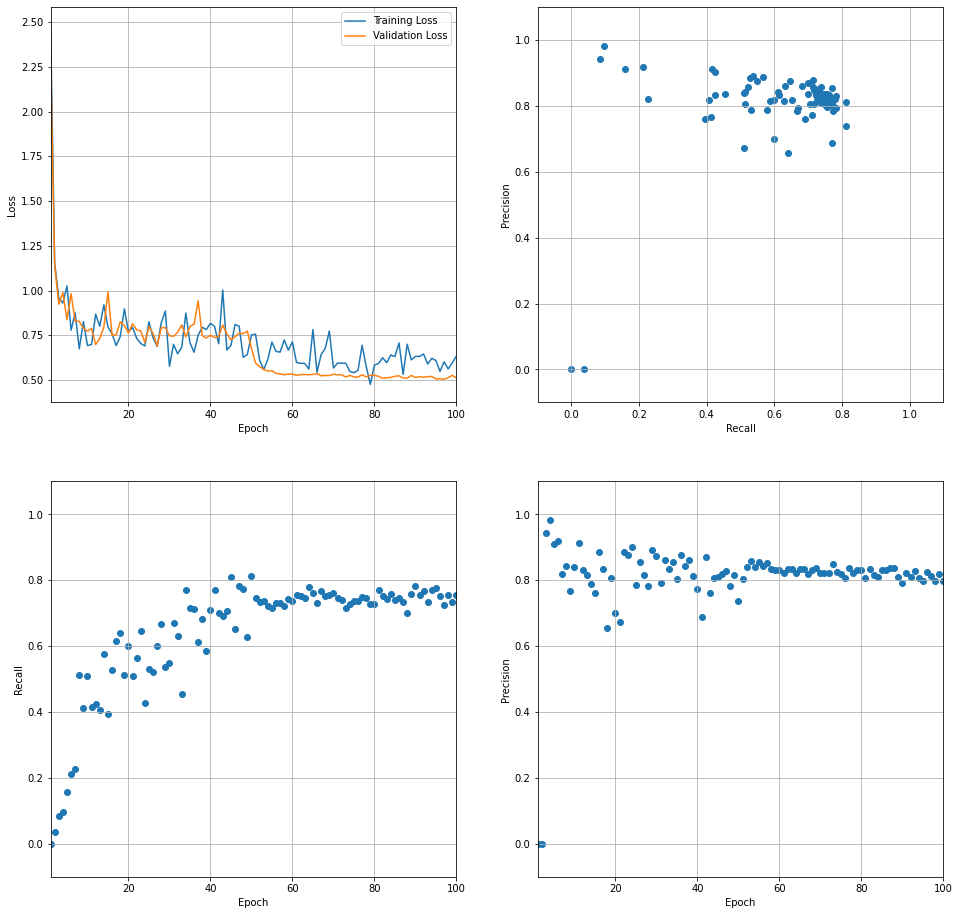

In [6]:
plot_stats('/content/drive/MyDrive/CDA/stats_100_pt.txt')

In [ ]:
# 50 epochs not pre-trained
set1 = PRcurve('/content/drive/MyDrive/CDA/ckpt_50.pth')
set1.save_stats('/content/drive/MyDrive/CDA/PRstats_set1')
set1.plot()

In [ ]:
# 50 epochs pre-trained
set2 = PRcurve('/content/drive/MyDrive/CDA/ckpt_50_pt.pth')
set2.save_stats('/content/drive/MyDrive/CDA/PRstats_set2')
set2.plot()


1/10: Confidence Threshold = 0.050


Computing AP: 100%|██████████| 1/1 [00:00<00:00, 195.98it/s]


---- mAP 0.76564 ----
Precision = 0.653, Recall = 0.840

2/10: Confidence Threshold = 0.100


Computing AP: 100%|██████████| 1/1 [00:00<00:00, 498.85it/s]


---- mAP 0.70184 ----
Precision = 0.798, Recall = 0.755

3/10: Confidence Threshold = 0.150


Computing AP: 100%|██████████| 1/1 [00:00<00:00, 693.73it/s]


---- mAP 0.58973 ----
Precision = 0.870, Recall = 0.620

4/10: Confidence Threshold = 0.200


Computing AP: 100%|██████████| 1/1 [00:00<00:00, 594.94it/s]


---- mAP 0.46298 ----
Precision = 0.929, Recall = 0.481

5/10: Confidence Threshold = 0.250


Computing AP: 100%|██████████| 1/1 [00:00<00:00, 566.64it/s]


---- mAP 0.31701 ----
Precision = 0.953, Recall = 0.327

6/10: Confidence Threshold = 0.300


Computing AP: 100%|██████████| 1/1 [00:00<00:00, 891.65it/s]


---- mAP 0.19677 ----
Precision = 0.962, Recall = 0.202

7/10: Confidence Threshold = 0.350


Computing AP: 100%|██████████| 1/1 [00:00<00:00, 1194.62it/s]


---- mAP 0.08656 ----
Precision = 0.965, Recall = 0.088

8/10: Confidence Threshold = 0.400


Computing AP: 100%|██████████| 1/1 [00:00<00:00, 1718.27it/s]


---- mAP 0.02564 ----
Precision = 1.000, Recall = 0.026

9/10: Confidence Threshold = 0.450


Computing AP: 100%|██████████| 1/1 [00:00<00:00, 2896.62it/s]


---- mAP 0.00000 ----
Precision = 0.000, Recall = 0.000

10/10: Confidence Threshold = 0.500


Computing AP: 100%|██████████| 1/1 [00:00<00:00, 1678.39it/s]


---- mAP 0.00000 ----
Precision = 0.000, Recall = 0.000


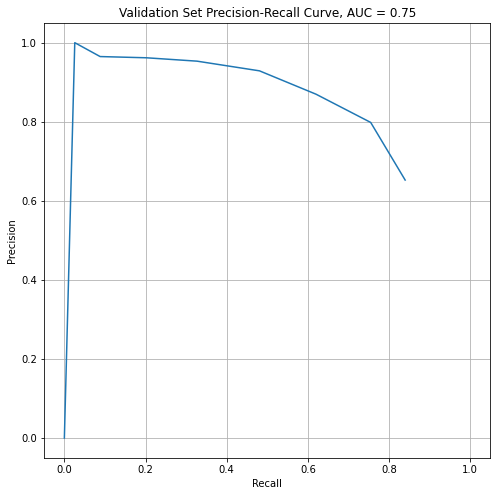

In [13]:
# 100 epochs pre-trained, learning rate step after 50 epochs
set3 = PRcurve('/content/drive/MyDrive/CDA/ckpt_100_pt.pth')
set3.save_stats('/content/drive/MyDrive/CDA/PRstats_set3')
set3.plot()

## Detections

In [15]:
# Perform detections on a directory

directory = '/content/YOLOv3-CDA/data/samples/'    # Sample Directory
#directory = '/content/YOLOv3-CDA/data/HiRISE/'      # Tiles from HiRISE

with open("/content/YOLOv3-CDA/data/sample_paths.txt", "w") as samples:
    n = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            samples.write(directory+file+"\n")
            n += 1

detect_directory('yolov3.cfg', '/content/drive/MyDrive/CDA/ckpt_100_pt.pth', directory, ['crater'], 'output', batch_size=1, n_cpu=2, conf_thres=0.2)

Detecting: 100%|██████████| 30/30 [00:01<00:00, 25.47it/s]


Image /content/YOLOv3-CDA/data/samples/aeolis_40_1.png:
Image /content/YOLOv3-CDA/data/samples/aeolis_42_5.png:
	+ Label: crater | Confidence: 0.3481
	+ Label: crater | Confidence: 0.2861
Image /content/YOLOv3-CDA/data/samples/aeolis_43_5.png:
	+ Label: crater | Confidence: 0.4202
	+ Label: crater | Confidence: 0.2931
Image /content/YOLOv3-CDA/data/samples/aeolis_54_5.png:
	+ Label: crater | Confidence: 0.2702
Image /content/YOLOv3-CDA/data/samples/amazonis_10_2.png:
	+ Label: crater | Confidence: 0.3715
Image /content/YOLOv3-CDA/data/samples/amazonis_10_26.png:
Image /content/YOLOv3-CDA/data/samples/amazonis_10_8.png:
	+ Label: crater | Confidence: 0.2684
	+ Label: crater | Confidence: 0.2299
Image /content/YOLOv3-CDA/data/samples/amazonis_25_1.png:
Image /content/YOLOv3-CDA/data/samples/amazonis_7_15.png:
	+ Label: crater | Confidence: 0.3164
Image /content/YOLOv3-CDA/data/samples/amazonis_8_14.png:
	+ Label: crater | Confidence: 0.2799
Image /content/YOLOv3-CDA/data/samples/tile_0_0

/content/YOLOv3-CDA/pytorchyolo/detect.py:231: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)
/content/YOLOv3-CDA/pytorchyolo/detect.py:230: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Image /content/YOLOv3-CDA/data/samples/tile_2_0.jpg:
	+ Label: crater | Confidence: 0.3214
Image /content/YOLOv3-CDA/data/samples/tile_2_1.jpg:
	+ Label: crater | Confidence: 0.2963
	+ Label: crater | Confidence: 0.2420
	+ Label: crater | Confidence: 0.2388
Image /content/YOLOv3-CDA/data/samples/tile_2_2.jpg:
	+ Label: crater | Confidence: 0.2329
Image /content/YOLOv3-CDA/data/samples/tile_2_3.jpg:
	+ Label: crater | Confidence: 0.3528
	+ Label: crater | Confidence: 0.3023
Image /content/YOLOv3-CDA/data/samples/tile_2_4.jpg:
	+ Label: crater | Confidence: 0.3973
	+ Label: crater | Confidence: 0.3804
	+ Label: crater | Confidence: 0.2555
Image /content/YOLOv3-CDA/data/samples/tile_3_0.jpg:
Image /content/YOLOv3-CDA/data/samples/tile_3_1.jpg:
	+ Label: crater | Confidence: 0.3132
Image /content/YOLOv3-CDA/data/samples/tile_3_2.jpg:
	+ Label: crater | Confidence: 0.2111
Image /content/YOLOv3-CDA/data/samples/tile_3_3.jpg:
	+ Label: crater | Confidence: 0.2504
	+ Label: crater | Confidence

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>